In [1]:
import numpy as np
import h5py
from sklearn.model_selection import ParameterGrid
from scipy.stats import linregress
from mirdata import tinysol
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from utilities.isomapEmbedding import isomapEmbedding
from utilities.convex_fit import convex_fit
from utilities.circle_projection import circle_projection
from utilities.centered import centered
from utilities.frobenius_distance import frobenius_distance
from utilities.d_squared import d_squared
from utilities.self_distance import self_distance

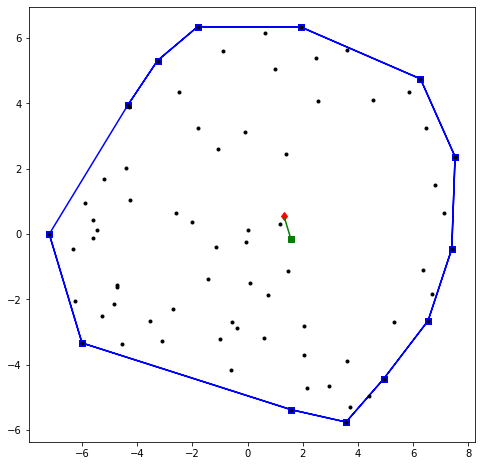

In [5]:
track_ids = tinysol.track_ids()
track_instrs = [track_id.split('-')[0] for track_id in track_ids]
instr_list = list(Counter(track_instrs).keys())

Q = 24
settings = {
    'Q': [24],
    'k': [3],
    'comp': ['log'],
    'instr': ['TpC']
}
settings_list = ParameterGrid(settings)

losses = {}
for setting in settings_list:
    # read precomputed features
    with h5py.File("TinySOL.h5", "r") as f:
        features_dict = {
            key:f[key][()]
            for key in f.keys()
            if setting["instr"] in key
        }
    batch_features = np.stack(list(features_dict.values()), axis=1)

    # compute isomap for subset
    isomap, freqs, rho_std = isomapEmbedding(batch_features)
    xyz_coords = isomap.fit_transform(rho_std)

    # convex hull fit, line fit
    xy_coords = xyz_coords[:, :2]
    xy_center, radius = convex_fit(xy_coords)
    xy_prime = circle_projection(xy_center, radius, xy_coords) # projected (x,y) coordinates

    z = xyz_coords[:, -1]
    z_fit = linregress(np.arange(len(z)), z)
    z_prime = np.asarray([i * z_fit.slope + z_fit.intercept for i, _ in enumerate(z)]) # projected z coordinates

    xyz_prime = np.concatenate((xy_prime, z_prime[:, np.newaxis]), axis=1)

    # store loss
    D_proj = self_distance(xyz_prime)
    D_isomap = self_distance(xyz_coords)

    loss = frobenius_distance(centered(D_proj), centered(D_isomap)) / xyz_prime.shape[0]
    losses[setting["instr"]] = loss


In [6]:
losses

{'TpC': 10.488564057425593}